# Logistic Regression in TensorFlow

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange         

# MNIST Example

The MNIST dataset is very popular machine learning dataset, consisting of 70000 grayscale images of handwritten digits, of dimensions 28x28. We'll be using it as our example for this section of the tutorial, with the goal being to predict which the digit is in each image.

Since it's such a common (and small) dataset, TensorFlow has commands for downloading and formatting the dataset conveniently baked in already:

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Let's take a look at how the data is organized:

Training image data:  (55000, 784)
Testing image data:  (10000, 784)
28 x 28 =  784

Train image 1 is labelled one-hot as [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


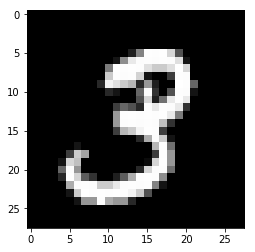

In [3]:
# Dataset statistics
print('Training image data: ', mnist.train.images.shape)
print('Testing image data: ', mnist.test.images.shape)
print('28 x 28 = ', 28*28)

# Example image
print('\nTrain image 1 is labelled one-hot as {0}'.format(mnist.train.labels[1,:]))
image = np.reshape(mnist.train.images[1,:],[28,28])
plt.imshow(image, cmap='gray')

### Logistic Regression Model

Define the graph input: this is where we feed in our training images into the model. Since MNIST digits are pretty small and the model we're using is very simple, we'll feed them in as flat vectors.

In [4]:
import tensorflow as tf
# Define input placeholder
X = tf.placeholder(tf.float32, [None, 784])

To get our predicted probabilities of each digit, let's first start with the probability of a digit being a 3 like the image above. For our simple model, we start by applying a linear transformation. That is, we multiply each value of the input vector by a weight, sum them all together, and then add a bias. In equation form:

\begin{align}
y_3 = \sum_i w_{i,3} x_i + b_3
\end{align}

The magnitude of this result $y_3$, we'll take as being correlated to our belief in how likely we think the input digit was a 3. The higher the value of $y_3$, the more likely we think the input image $x$ was a 3 (ie, we'd hope we'd get a relatively large value for $y_3$ for the above image). Remember though, our original goal was to identify all 10 digits, so we also have:

\begin{align*}
y_0 =& \sum_i w_{i,0} x_i + b_0 \\
&\vdots \\
y_9 =& \sum_i w_{i,9} x_i + b_9
\end{align*}

We can express this in matrix form as:

\begin{align}
y = W x + b 
\end{align}

To put this into our graph in TensorFlow, we need to define some Variables to hold the weights and biases:

In [5]:
# Define linear transformation
W = tf.Variable(tf.truncated_normal([784, 10], stddev=0.1))
b = tf.Variable(tf.truncated_normal([10], stddev=0.1))
scores = tf.matmul(X, W) + b

We can interpret these values (aka logits) $y$ as probabilities if we normalize them to be positive and add up to 1. In logistic regression, we do this with a softmax:

\begin{align}
p(y_i) = \text{softmax}(y_i) = \frac{\text{exp}(y_i)}{\sum_j\text{exp}(y_j)}
\end{align}

Notice that because the range of the exponential function is always non-negative, and since we're normalizing by the sum, the softmax achieves the desired property of producing values between 0 and 1 that sum to 1.

Computing a softmax in TensorFlow is pretty easy, sort of*:

*&#42;More on this later*

In [6]:
# Softmax to probabilities
p_scores = tf.nn.softmax(scores)

That defines our forward pass of our model! We now have a graph that performs a forward pass: given an input image, the graph returns the probabilities the model thinks the input is each of the 10 classes. Are we done?

Not quite. We don't know the values of $W$ and $b$ yet. We're going to learn those by defining a loss and using gradient descent to do backpropagation. Essentially, we'll be taking the derivative with respect to each of the elements in $W$ and $b$ and wiggling them in a direction that reduces our loss.

The loss we commonly use in classification is cross-entropy. Cross-entropy is a concept from information theory:

\begin{align}
H_{y'}(y)=-\sum_i y'_i \text{log}(y_i)
\end{align}

Cross-entropy not only captures how *correct* (max probability corresponds to the right answer) the model's answers are, it also accounts for how *confident* (high confidence in correct answers) they are. This encourages the model to produce very high probabilities for correct answers while driving down the probabilities for the wrong answers, instead of merely be satisfied with it being the argmax. 

In supervised models, we need labels to learn, so we create a placeholder for the labels in our training data:

In [7]:
# Define labels placeholder
y = tf.placeholder(tf.float32, [None, 10])

The cross-entropy loss is pretty easy to implement:

In [8]:
# Loss
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=scores, labels=y))

In the old days, we would have to go through and derive all the gradients ourselves, then code them into our program. Nowadays, we have libraries to compute all the gradients automatically. Not only that, but TensorFlow comes with a whole suite of optimizers implementing various optimization algorithms. I'm not going to go into the details of why you should appreciate that right now, because I know that Prof David Carlson has an entire day's worth of material on optimization.

In [9]:
# Optimizer
train_step = tf.train.GradientDescentOptimizer(0.05).minimize(cross_entropy)

To train, we simply call the optimizer op we defined above. First though, we need to start a session and initialize our variables:

In [10]:
# Create a session object and initialize all graph variables
sess = tf.Session()
sess.run(tf.global_variables_initializer())

There are much cleverer ways to design a training regimen that stop training once the model is converged and before it starts overfitting, but for this demo, we'll keep it simple:

In [11]:
# Train the model
# trange is a tqdm function. It's the same as range, but adds a pretty progress bar
for epoch in trange(50):
    for which_batch in range(550):
        batch_xs = mnist.train.images[which_batch*100:(which_batch+1)*100]
        batch_ys = mnist.train.labels[which_batch*100:(which_batch+1)*100]
        sess.run(train_step, feed_dict={X: batch_xs, y: batch_ys})

100%|██████████| 50/50 [00:16<00:00,  2.89it/s]


Notice, because of the way the dependency links are connected in our graph, running the optimizer requires an input to both the training image placeholder `X` and the training label placeholder `y` (as it should). The values of all variables (`W` and `b`) are updated in place automatically by the optimizer.

Now let's see how we did! For every image in our test set, we run the data through the model, and take the digit in which we have the highest confidence as our answer. We then compute an accuracy by seeing how many we got correct:

In [12]:
# Test trained model
correct_prediction = tf.equal(tf.argmax(scores, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Test accuracy: {0}'.format(sess.run(accuracy, feed_dict={X: mnist.test.images, y: mnist.test.labels})))

Test accuracy: 0.9221000075340271


Not bad for a simple model and a few lines of code.  Before we close the session, there's one more interesting thing we can do. Normally, it can be difficult to inspect exactly what the filters in a model are doing, but since this model is so simple, and the weights transform the data directly to their logits, we can actually visualize what the model's learning by simply plotting the weights.

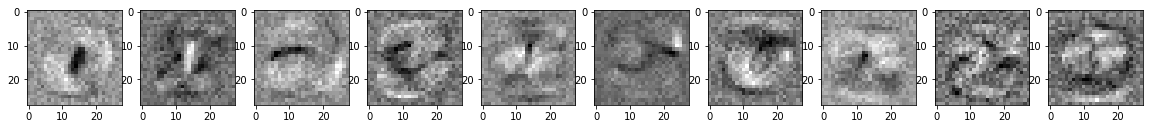

In [13]:
# Get weights
weights = sess.run(W)

fig, ax = plt.subplots(1, 10, figsize=(20, 2))

for digit in range(10):
    ax[digit].imshow(weights[:,digit].reshape(28,28), cmap='gray')

# Close session to finish
sess.close()

*Acknowledgment: Material adapted from the TensorFlow tutorial: https://www.tensorflow.org/get_started/*